(Kalman:kalman)=
# Kalman Filter
The Kalman Filter origins from the work of Norbert Wiener's in the 1940s {cite}`wiener1949`. The central problem to his works was the separation of the signal from the additive combination of signal and noise. One could say that Wiener's main contribution was the formulation of the problem in terms of minimizing the mean square error in th time domain - as opposed to the frequency domain which was the dominating approach at the time.

In the 1960 Rudolf Emil Kalman considerred the same problem as Wiener. In his famous paper {cite}`kalman1960` he introduced the discrete formulation together with the state-space notation in the time domain which gained imediate popularity empowered by the advances in computer technology at the time. The Kalman Filter was early adopted by the navigation community, and is today regarded as the main workhorse for the vast majority of navigation applications.

So, what is a Kalman Filter?

![navigation](fig/navigation.jpg)

```{note}
A Kalman Filter is an recursive algorithm that provides estimates of a state vector as a weighted sum of the forward propagation of the previous state vector, and the current measurements.
```

## Intuitive idea
Let's make a simple thought experiment. Assume two persons sitting in a boat that floats freely on the ocean. At one point in time both persons measures the boats position.

Let's assume the first person measure the position to be $z_1$ with a corresponding variance $\sigma_{z_1}^2$. What is the best estimate of the boats position?

If we only use this measurement, we get the following estimate of the boats position and variance.

$$
\begin{align}
  \hat{x}_1 =& z_1\\
  \hat{\sigma}_{x_1}^2 =& \sigma_{z_1}^2\\
\end{align}
$$

Then the second person measures the position to be $z_2$ with a corresponding variance $\sigma_{z_2}^2$. What is the best estimate of the boats position now?

If we chose to make use of both measurements, we can combine them in the following way:

$$
\begin{align}
  \hat{x}_2 =& \hat{x}_1 + K(z_2 - \hat{x}_1)\\
  \hat{\sigma}_{x_2} =& K \sigma_{z_2}^2\\
\end{align}
$$

, where $K = \frac{\hat{\sigma}_{x_1}^2}{\hat{\sigma}_{x_1}^2 + \sigma_{z_2}^2}$. This value is also called *gain*, and it weights the contribution of the new measurement to the existing estimate of the position.

Assume both persons measure the position with the same precision, i.e. $\sigma_{z_1}^2 = \sigma_{z_2}^2$. In this particular case we get $K = \frac{1}{2}$. We can then write:

$$
\begin{align}
  \hat{x}_2 =& \hat{x}_1 + \frac{1}{2}(z_2 - \hat{x}_1) = \frac{1}{2}(z_1 + z_2)\\
  \hat{\sigma}_{x_2} =& \frac{1}{2} \sigma_{z_2}^2 = \frac{\sigma_{z_2}^2}{2}\\
\end{align}
$$

This we immediately recognize as the *mean value* of both measurements - a result that intuitively sounds reasonable.

However, the difference between the two persons measurements isn't just due to measurement errors alone, but will also be due to the motion of the boat itself. So, a Kalman filter will in addition to this *measurement model* also include a *dynamic model* that describes the boats motions while floating (e.g. a small rubber boat will have a very different motion than a large ship).

## Dynamic equations
As we saw in {ref}`System:system`, we typically use a set of ordinary differential equations (ODEs) to model the physical behaviour of the system. They can be expressed through linear dynamic equations as follows:

$$
\dot{x}=Fx + Gu
$$

In order to solve these dynamic equations, we have several options depending on the properties of $F$ and $G$. However, in this very first approach we will use the approximate solution as follows:

$$
\begin{align}
  \phi=&I + F\Delta t + \frac{(F\Delta t)^2}{2!} + \dots\\
  Q_k =& \int_{t_k}^{t_{k+1}} \phi(t_{k+1}, \epsilon) G(\epsilon) G^T(\epsilon) \phi^T(t_{k+1}, \epsilon) d\epsilon\\
\end{align}
$$

## Discrete Kalman Filter
So, the two main components of a Kalman Filter are the *dynamic model* and the *measurement model*. The first one models the dynamic behaviour of the platform through a set of differential equations, while the latter provides the connection between the available measurements and the elements of the state vector.

Note that if either the dynamic equations or the measurement equations are non-linear, they have to be linearized first in order to fit the general linear Kalman Filter equations. This linearization step introduces the need to establish *preliminary values* to the unknowns.

Since the Kalman Filter are derived from the {ref}`Bayes:bayes` it also will consist of a *correction step* and a *prediction step*. These two components forms what is known as the *discrete Kalman Filter loop*.

```{figure} fig/kf_loop.png
:name: kf_loop

Kalman Filter loop
```

*Predict:*

$$
\begin{align}
  \tilde x_{k}=&\phi_{k-1} \hat x_{k-1}\\
  \tilde P_{k}=&\phi_{k-1} P_{k-1} \phi^T_{k-1}+Q_{k-1}\\
\end{align}
$$

*Correct:*

$$
\begin{align}
  K_{k}=&\tilde P_{k}H^{T}_{k}(H_{k} \tilde P_{k}H^{T}_{k}+R_{k})^{-1}\\
  \hat x_{k}=&\tilde x_{k}+K_{k}(z_{k}-H_{k} \tilde x_{k})\\
  \hat P_{k}=&(I-K_{k}H_{k}) \tilde P_{k}\\
\end{align}
$$

### Example 5.1
Let's revisit our well known Trolley on rails and use this as our very first example of a simple Kalman Filter implementation. As before, the Trolley is equipped with a laser scanner that continously measures the distance to a wall.

```{figure} fig/laserscan.png
:name: laserscan2

Laser scanner
```

Assume that the trolley is at rest and not moving. This is not very exiting example for the Kalman filter, however it might be a useful start to see how it deals with measurements from a stationary platform. In this particular example we use the first measurement as our initial value. Thus, the initial state vector becomes:

$$
x_0=
\begin{bmatrix}
  z_1\\
\end{bmatrix}
$$
  
A simplistic system model could then look something like this:

$$
\begin{bmatrix}
  \dot{x}\\
\end{bmatrix}
=
\begin{bmatrix}
  0\\
\end{bmatrix}
\begin{bmatrix}
  x\\
\end{bmatrix}
+
\begin{bmatrix}
  \sqrt{q_p}\\
\end{bmatrix}
u
$$

As we are very certain about the dynamic behavior of the platform (i.e. the position is constant), we introduce a rather small value for the process noise on the position $q_p$ indicating that we have modelled the position to be constant and that it will not change. This dynamic model that contains no time derivatives in the state vector is often denoted as a *P-model*.

Note that eventhough it might be tempting to set the value to zero, it is not recommended to do so as there is a high risk to run into numerical instabilites dealing with the covariance matrices.

Further, the measurement model is given as:

$$
\begin{bmatrix}
  z
\end{bmatrix}
=
\begin{bmatrix}
  1\\
\end{bmatrix}
\begin{bmatrix}
  x\\
\end{bmatrix}
+
\begin{bmatrix}
  v
\end{bmatrix}
$$

Let's try this simplistic Kalman Filter model with our previous measurements. It will look something like this.

In [1]:
# Compute transistion matrix and process noise matrix

# Import
from sympy import Symbol, Matrix, sqrt, eye, integrate

# Define symbols
dt = Symbol('\Delta t')
qp = Symbol('q_p')

# Dynamic matrix
F = Matrix([[0]])

# Transition matrix
phi = eye(1) + F*dt
display(phi)

# White noise coefficients
G = Matrix([[sqrt(qp)]])

# Process noise matrix
Q = integrate(phi@G@G.T@phi.T,  (dt, 0, dt))
display(Q)

<>:7: SyntaxWarning: invalid escape sequence '\D'
<>:7: SyntaxWarning: invalid escape sequence '\D'
/var/folders/t_/w8vzb4yn72g_lxn9c_zk48w40000gn/T/ipykernel_3013/4020509331.py:7: SyntaxWarning: invalid escape sequence '\D'
  dt = Symbol('\Delta t')


Matrix([[1]])

Matrix([[\Delta t*q_p]])

In [2]:
# Simple Kalman Filter (P-model)
# Measurement:
# Distance [meter]

# Import
from numpy import array, mean, var, arange, sqrt, eye, negative
from numpy.linalg import inv
import matplotlib.pyplot as plt

# Measurements
z = array([[51.34],
           [48.17],
           [49.02],
           [50.97],
           [51.23],
           [50.72],
           [48.95],
           [49.45],
           [52.07],
           [50.52]])

# System values
dt = 1                # interval [second]
samples = len(z)      # number of samples
qp = 1e-8**2          # process noise [meter^2/second]
rp = var(z, ddof=1)   # measurement noise [meter^2]

# Initial state vector
x0 = array([z[0]])  # position [meter]
x = x0

# Initial state covariance matrix
P0 = array([[100**2]])   # position [meter^2]
P = P0

# Transition matrix
phi = array([[1]])

# Process noise matrix
Q = array([[qp*dt]])

# Design matrix
H = array([[1]])

# Measurement covariance matrix
R = array([[rp]])

# Initialize plot lists
x_all = []; P_all = []; z_all = []

# Main loop
for k in range(0, samples):
    
    # Time update
    xp = phi@x
    Pp = phi@P@phi + Q
    
    # Kalman gain
    K = Pp@H.T@inv(H@Pp@H.T + R)
    
    # Measurement update
    x = xp + K@(z[k] - H@xp)
    P = (eye(1) - K@H)@Pp
    
    # Accumulate plot lists
    z_all.append(z[k])
    x_all.append(x)
    P_all.append(P)

# Extract plot lists
pos = [x[0, 0] for x in x_all]
sd = [sqrt(P[0, 0]) for P in P_all]
meas = [z[0] for z in z_all]

mu = x[0]
se = sqrt(P[0, 0])

print("Measurements       : " + ' '.join(f'{meas:.2f}' for meas in meas))
print("Estimated position : " + ' '.join(f'{pos:.2f}' for pos in pos))

# Time
time = arange(0, samples)*dt

# Plot results
plt.title('Accumulated Mean Value')
plt.plot(time, pos, color='g', label='Estimated distance')
plt.plot(time, meas, color='r', marker='o', linestyle='none', label='Measured distance')
plt.axhline(y=mu, color='m', linestyle='dashed', label='Mean distance')
plt.xlabel('# of measurements')
plt.ylabel('Distance (meter)')

plt.plot(time, mu + sd, alpha=0.5, color='g', linestyle='dotted', label='Estimated error')
plt.plot(time, mu + negative(sd), alpha=0.5, color='g', linestyle='dotted')
plt.fill_between(time, mu + sd, mu + negative(sd), alpha=0.2)
plt.axhline(y=mu + se, alpha=0.5, color='m', linestyle='dotted',label='Standard error')
plt.axhline(y=mu - se, alpha=0.5, color='m', linestyle='dotted')

plt.legend(loc='lower right')
plt.show()

ModuleNotFoundError: No module named 'matplotlib'

Note that the Kalman Filter in this simple example, were we are estimating a constant, actually reproduces our previous results from {ref}`Intro:mean_and_variance` where we computed the recursive mean value. This might build us some trust in that the Kalman Filter treats the information in the very same way, i.e. it is optimal in the sense of *minimum variance*.

### Example 5.2
To make the Kalman Filter really come into play, we need to allow for some movement of the Trolley. Assume we give the Trolley a slight push so that it starts rolling on the rails. To allow for this in the Kalman Filter, we must modify the dynamic model to take not only the position into account, but also the velocity.

```{figure} fig/laserscan.png
:name: laserscan3

Laser scanner
```

The dynamic model will then look like this.

$$
\begin{bmatrix}
  \dot{x}\\
  \ddot{x}\\
\end{bmatrix}
=
\begin{bmatrix}
  0 &1\\
  0 &0\\
\end{bmatrix}
\begin{bmatrix}
  x\\
  \dot{x}\\
\end{bmatrix}
+
\begin{bmatrix}
  0\\
  \sqrt{q_v}\\
\end{bmatrix}
u
$$

Note that in this example, the Trolley rolls on the rails with some randomness associated with the velocity. This is modelled with the white noise coefficient $q_v$ that introduces some process noise on the second differential equation that is connected to the velocity element in the state vector. This model is often denoted as a *PV-model*.

Since the only measurements involved are the continous distance measurements from the laser scanner, the measurement model can be written like this.

$$
\begin{bmatrix}
  z
\end{bmatrix}
=
\begin{bmatrix}
  1 &0\\
\end{bmatrix}
\begin{bmatrix}
  x\\
  \dot{x}\\
\end{bmatrix}
+
\begin{bmatrix}
  v
\end{bmatrix}
$$

To implement our modified Kalman Filter model we need to generate a set of synthetic measurements to simulate the output from the laser scanner as the Trolley rolls on the rails.

In [3]:
# Compute transistion matrix and process noise matrix

# Import
from sympy import Symbol, Matrix, sqrt, eye, integrate

# Define symbols
dt = Symbol('\Delta t')
qv = Symbol('q_v')

# Dynamic matrix
F = Matrix([[0, 1],
            [0, 0]])

# Transition matrix
phi = eye(2) + F*dt
display(phi)

# White noise coefficients
G = Matrix([[0],
            [sqrt(qv)]])

# Process noise matrix
Q = integrate(phi@G@G.T@phi.T,  (dt, 0, dt))
display(Q)

Matrix([
[1, \Delta t],
[0,        1]])

Matrix([
[\Delta t**3*q_v/3, \Delta t**2*q_v/2],
[\Delta t**2*q_v/2,      \Delta t*q_v]])

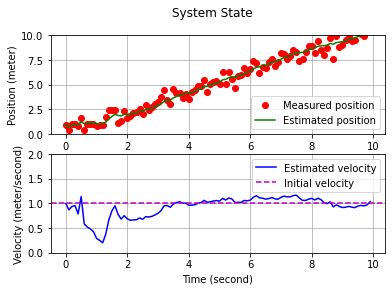

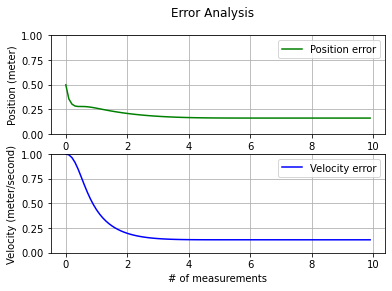

Error statistics:
Position standard deviation: 0.163 m
Velocity standard deviation: 0.132 m/s


In [4]:
# Simple Kalman Filter (PV-model)
# Measurement: Distance [meter]

# Import
from numpy import array, sqrt, eye, arange
from numpy.random import normal
from numpy.linalg import inv, cholesky
import matplotlib.pyplot as plt

# System values
dt = 0.1       # interval [second]
samples = 100  # number of samples
qv = 0.1**2    # process noise [(meter/second)^2/second]
rp = 0.5**2    # measurement noise [meter^2]

# Initial state vector
x0 = array([[0],    # position [meter]
            [1]])   # velocity [meter/second]
xt = x0; x = x0

# Initial covariance matrix
P0 = array([[10**2, 0],   # position [meter^2]
            [0, 1**2]])   # velocity [(meter/second)^2]
P = P0

# Transition matrix
phi = array([[1, dt],
             [0, 1]])

# Process noise
Q = array([[1/3*qv*dt**3, 1/2*qv*dt**2],
           [1/2*qv*dt**2, qv*dt]])

# Cholesky decomposition
C = cholesky(Q)

# Design matrix
H = array([[1, 0]])

# Measurement covariance matrix
R = array([[rp]])

# Initialize plot lists
x_all = []; P_all = []; z_all = []

# Main loop
for k in range(0, samples):
    
    # Process noise vector
    w = array([[0],
               [normal(0, 1)]])
    
    # Compute true trajectory
    xt = phi@xt + C@w
    
    # Generate noisy measurements
    z = H@xt + normal(0, sqrt(rp))
    
    # Time update
    xp = phi@x
    Pp = phi@P@phi.T + Q
    
    # Kalman gain
    K = Pp@H.T@inv(H@Pp@H.T + R)
    
    # Measurement update
    x = xp + K@(z - H@xp)
    P = (eye(2) - K@H)@Pp
    
    # Accumulate plot vectors
    x_all.append(x)
    P_all.append(P)
    z_all.append(z)

# Extract plot vectors
pos = [x[0, 0] for x in x_all]
vel = [x[1, 0] for x in x_all]
pos_sd = [sqrt(P[0, 0]) for P in P_all]
vel_sd = [sqrt(P[1, 1]) for P in P_all]
meas = [z[0, 0] for z in z_all]

# Time
time = arange(0, samples)*dt

# Plot results
fig, (ax1, ax2) = plt.subplots(2)
fig.suptitle('System State')
ax1.plot(time, meas, 'ro', label='Measured position')
ax1.plot(time, pos, 'g', label = 'Estimated position')
ax1.set_ylabel('Position (meter)')
ax1.set_ylim(0, 10)
ax1.legend(loc='lower right')
ax1.grid(True, which='both')
ax2.plot(time, vel, 'b', label = 'Estimated velocity')
ax2.axhline(y=x0[1], color='m', linestyle='--', label='Initial velocity')
ax2.set_xlabel('Time (second)')
ax2.set_ylabel('Velocity (meter/second)')
ax2.set_ylim(0, 2)
ax2.legend(loc='best')
ax2.grid(True, which='both')
plt.show()

fig, (ax1, ax2) = plt.subplots(2)
fig.suptitle('Error Analysis')
ax1.plot(time, pos_sd, 'g', label='Position error')
ax1.set_ylabel('Position (meter)')
ax1.set_ylim(0, 1)
ax1.legend(loc='best')
ax1.grid(True, which='both')
ax2.plot(time, vel_sd, 'b', label='Velocity error')
ax2.set_xlabel('# of measurements')
ax2.set_ylabel('Velocity (meter/second)')
ax2.set_ylim(0, 1)
ax2.legend(loc='best')
ax2.grid(True, which='both')
plt.show()

print("Error statistics:")
print(f"Position standard deviation: {pos_sd[-1]:.3f} m")
print(f"Velocity standard deviation: {vel_sd[-1]:.3f} m/s")

Note that the estimated error of the first position estimate is equal to the precision of the first distance measurement itself, while the estimated velocity error at this point is equal to the initial position error. This is due to the need of two distance measurements to provide information about the velocity, thus in this very first epoch the velocity estimate will be solely based on the dynamic model.

## State Estimation
As we have seen, the Kalman Filter provides estimates of the current state vector as a weighted balance between the dynamic model and the measurement model. One of the main properties of the filter is that it is capable of providing estimates of the complete state vector even if there is not measurements available for all the individual elements.

This is a very important property of the Kalman Filter and we will illustrate this through a simple example. In the example above, we measured distances with a laser scanner and obtained fairly good estimates of both position and velocity eventhough we have no sensor that measures velocity. The velocity estimate is obtained thanks to the dynamic model that links the two quantities through the system of ODEs.

### Example 5.3
But what happens if we do not have a laser scanner, but the only sensor is a speedometer? Can we still get estimates of both position and velocity? Let's assume the same dynamic model as in the previous example, but this time with only a speedometer available.

```{figure} fig/speed.png
:name: speed

Speedometer
```

The dynamic model will is the same as before, but we write it again here for completness.

$$
\begin{bmatrix}
  \dot{x}\\
  \ddot{x}\\
\end{bmatrix}
=
\begin{bmatrix}
  0 &1\\
  0 &0\\
\end{bmatrix}
\begin{bmatrix}
  x\\
  \dot{x}\\
\end{bmatrix}
+
\begin{bmatrix}
  0\\
  \sqrt{q_v}\\
\end{bmatrix}
u
$$

Since the only measurements involved are the velocity measurements from the speedometer, the measurement model can be written like this.

$$
\begin{bmatrix}
  z
\end{bmatrix}
=
\begin{bmatrix}
  0 &1\\
\end{bmatrix}
\begin{bmatrix}
  x\\
  \dot{x}\\
\end{bmatrix}
+
\begin{bmatrix}
  v
\end{bmatrix}
$$

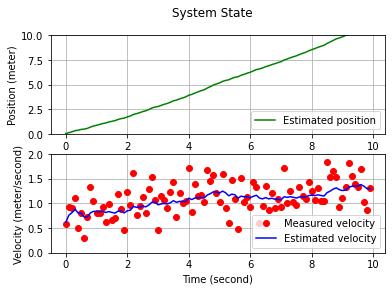

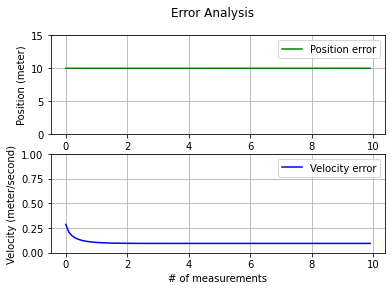

Error statistics:
Position standard deviation: 10.005 m
Velocity standard deviation: 0.095 m/s


In [5]:
# Simple Kalman Filter (PV_model)
# Measurement: Velocity [meter/second]

# Import
from numpy import array, sqrt, eye, arange
from numpy.random import normal
from numpy.linalg import inv, cholesky
import matplotlib.pyplot as plt

# System values
dt = 0.1       # interval [second]
samples = 100  # number of samples
qv = 0.1**2    # process noise [(meter/second)^2/second]
rv = 0.3**2    # measurement noise [(meter/second)^2]

# Initial state vector
x0 = array([[0],    # position [meter]
            [1]])   # velocity [meter/second]
xt = x0; x = x0

# Initial covariance matrix
P0 = array([[10**2, 0],   # position [meter^2]
            [0, 1**2]])   # velocity [(meter/second)^2]
P = P0

# Transition matrix
phi = array([[1, dt],
             [0, 1]])

# Process noise
Q = array([[1/3*qv*dt**3, 1/2*qv*dt**2],
           [1/2*qv*dt**2, qv*dt]])

# Cholesky decomposition
C = cholesky(Q)

# Design matrix
H = array([[0, 1]])

# Measurement covariance matrix
R = array([[rv]])

# Initialize plot lists
x_all = []; P_all = []; z_all = []

# Main loop
for k in range(0, samples):
    
    # Process noise vector
    w = array([[0],
               [normal(0, 1)]])
    
    # Compute true trajectory
    xt = phi@xt + C@w
    
    # Generate noisy measurements
    z = H@xt + normal(0, sqrt(rv))
    
    # Time update
    xp = phi@x
    Pp = phi@P@phi.T + Q
    
    # Kalman gain
    K = Pp@H.T@inv(H@Pp@H.T + R)
    
    # Measurement update
    x = xp + K@(z - H@xp)
    P = (eye(2) - K@H)@Pp
    
    # Accumulate plot vectors
    x_all.append(x)
    P_all.append(P)
    z_all.append(z)

# Extract plot vectors
pos = [x[0] for x in x_all]
vel = [x[1] for x in x_all]
pos_sd = [sqrt(P[0, 0]) for P in P_all]
vel_sd = [sqrt(P[1, 1]) for P in P_all]
meas = [z[0, 0] for z in z_all]

# Time
time = arange(0, samples)*dt

# Plot results
fig, (ax1, ax2) = plt.subplots(2)
fig.suptitle('System State')
ax1.plot(time, pos, 'g', label = 'Estimated position')
ax1.set_ylabel('Position (meter)')
ax1.set_ylim(0, 10)
ax1.legend(loc='lower right')
ax1.grid(True, which='both')
ax2.plot(time, meas, 'ro', label='Measured velocity')
ax2.plot(time, vel, 'b', label = 'Estimated velocity')
ax2.set_xlabel('Time (second)')
ax2.set_ylabel('Velocity (meter/second)')
ax2.set_ylim(0, 2)
ax2.legend(loc='best')
ax2.grid(True, which='both')
plt.show()

fig, (ax1, ax2) = plt.subplots(2)
fig.suptitle('Error Analysis')
ax1.plot(time, pos_sd, 'g', label='Position error')
ax1.set_ylabel('Position (meter)')
ax1.set_ylim(0, 15)
ax1.legend(loc='best')
ax1.grid(True, which='both')
ax2.plot(time, vel_sd, 'b', label='Velocity error')
ax2.set_xlabel('# of measurements')
ax2.set_ylabel('Velocity (meter/second)')
ax2.set_ylim(0, 1)
ax2.legend(loc='best')
ax2.grid(True, which='both')
plt.show()

print("Error statistics:")
print(f"Position standard deviation: {pos_sd[-1]:.3f} m")
print(f"Velocity standard deviation: {vel_sd[-1]:.3f} m/s")

Note that the estimated error of the velocity decreases as more velocity measurements become available. However, the estimated position error starts with the initial position error and then remains constant as a function of time.

The reason for this is that we only have measurements of the velocity, thus there is no new information available for the initial position and the filter is then responding with a constant error that is equal to the initial position error.

Thus measuring only the velocity, the position becomes *unobservable*.

### Example 5.4
So, how do we then make use of both sensors, i.e. laser scanner and speedometer? Let's assume the same dynamic model as in both the previous examples, but this time with both laser scanner and speedometer available.

```{figure} fig/laserscan_speed.png
:name: laserscanspeed

Laser scanner and speedometer
```

Again the dynamic model is the same as before, but we write it again here for completness.

$$
\begin{bmatrix}
  \dot{x}\\
  \ddot{x}\\
\end{bmatrix}
=
\begin{bmatrix}
  0 &1\\
  0 &0\\
\end{bmatrix}
\begin{bmatrix}
  x\\
  \dot{x}\\
\end{bmatrix}
+
\begin{bmatrix}
  0\\
  \sqrt{q_v}\\
\end{bmatrix}
u
$$

Since the measurements involved are both the distance measurements from the laser scanner and the velocity measurements from the speedometer, the measurement model can be written like this.

$$
\begin{bmatrix}
  z_1\\
  z_2\\
\end{bmatrix}
=
\begin{bmatrix}
  1 &0\\
  0 &1\\
\end{bmatrix}
\begin{bmatrix}
  x\\
  \dot{x}\\
\end{bmatrix}
+
\begin{bmatrix}
  v_1\\
  v_2\\
\end{bmatrix}
$$

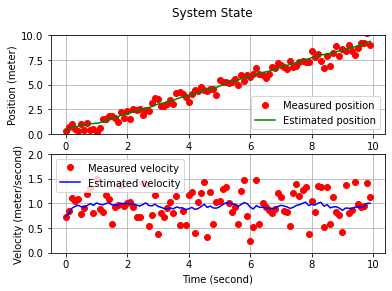

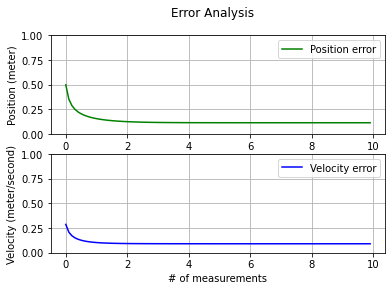

Error statistics:
Position standard deviation: 0.116 m
Velocity standard deviation: 0.091 m/s


In [6]:
# Simple Kalman Filter (PV_model)
# Measurement: Position [meter] and Velocity [meter/second]

# Import
from numpy import array, sqrt, eye, arange, diag
from numpy.random import normal
from numpy.linalg import inv, cholesky
import matplotlib.pyplot as plt

# System values
dt = 0.1       # interval [second]
samples = 100  # number of samples
qv = 0.1**2    # process noise [(meter/second)^2/second]
rp = 0.5**2    # position measurement noise [meter^2]
rv = 0.3**2    # velocity measurement noise [(meter/second)^2]

# Initial state vector
x0 = array([[0],    # position [meter]
            [1]])   # velocity [meter/second]
xt = x0; x = x0

# Initial covariance matrix
P0 = array([[10**2, 0],   # position [meter^2]
            [0, 1**2]])   # velocity [(meter/second)^2]
P = P0

# Transition matrix
phi = array([[1, dt],
             [0, 1]])

# Process noise
Q = array([[1/3*qv*dt**3, 1/2*qv*dt**2],
           [1/2*qv*dt**2, qv*dt]])

# Cholesky decomposition
C = cholesky(Q)

# Design matrix
H = eye(2)

# Measurement covariance matrix
R = diag([rp, rv])

# Initialize plot lists
x_all = []; P_all = []; z_all = []

# Main loop
for k in range(0, samples):
    
    # Process noise vector
    w = array([[0],
               [normal(0, 1)]])
    
    # Compute true trajectory
    xt = phi@xt + C@w
    
    # Generate noisy measurements
    z = H@xt + array([[normal(0, sqrt(rp))],
                      [normal(0, sqrt(rv))]])
    
    # Time update
    xp = phi@x
    Pp = phi@P@phi.T + Q
    
    # Kalman gain
    K = Pp@H.T@inv(H@Pp@H.T + R)
    
    # Measurement update
    x = xp + K@(z - H@xp)
    P = (eye(2) - K@H)@Pp
    
    # Accumulate plot vectors
    x_all.append(x)
    P_all.append(P)
    z_all.append(z)

# Extract plot vectors
pos = [x[0] for x in x_all]
vel = [x[1] for x in x_all]
pos_sd = [sqrt(P[0, 0]) for P in P_all]
vel_sd = [sqrt(P[1, 1]) for P in P_all]
meas_pos = [z[0, 0] for z in z_all]
meas_vel = [z[1, 0] for z in z_all]

# Time
time = arange(0, samples)*dt

# Plot results
fig, (ax1, ax2) = plt.subplots(2)
fig.suptitle('System State')
ax1.plot(time, meas_pos, 'ro', label='Measured position')
ax1.plot(time, pos, 'g', label = 'Estimated position')
ax1.set_ylabel('Position (meter)')
ax1.set_ylim(0, 10)
ax1.legend(loc='lower right')
ax1.grid(True, which='both')
ax2.plot(time, meas_vel, 'ro', label='Measured velocity')
ax2.plot(time, vel, 'b', label = 'Estimated velocity')
ax2.set_xlabel('Time (second)')
ax2.set_ylabel('Velocity (meter/second)')
ax2.set_ylim(0, 2)
ax2.legend(loc='best')
ax2.grid(True, which='both')
plt.show()

fig, (ax1, ax2) = plt.subplots(2)
fig.suptitle('Error Analysis')
ax1.plot(time, pos_sd, 'g', label='Position error')
ax1.set_ylabel('Position (meter)')
ax1.set_ylim(0, 1)
ax1.legend(loc='best')
ax1.grid(True, which='both')
ax2.plot(time, vel_sd, 'b', label='Velocity error')
ax2.set_xlabel('# of measurements')
ax2.set_ylabel('Velocity (meter/second)')
ax2.set_ylim(0, 1)
ax2.legend(loc='best')
ax2.grid(True, which='both')
plt.show()

print("Error statistics:")
print(f"Position standard deviation: {pos_sd[-1]:.3f} m")
print(f"Velocity standard deviation: {vel_sd[-1]:.3f} m/s")

Thus, when combining both the laser scanner and the speedometer we actually obtain better estimates for both position and velocity compared to either sensor alone. This seems reasonable as we now use all the information available from both sensors.

## Joseph Form
In order to keep the numerical stability of the measurement update of the estimated covariance matrix $\hat P_{k}$, we normally use the so called Joseph form of the matrix equation. This form has natural symmetry and is valid for any gain, wether optimal or suboptimal. The Joseph form can be written like this.

$$
\hat P_{k}=(I-K_{k}H_{k})\tilde P_{k}(I-K_{k}H_{k})^T+K_{k}R_{k}K_{k}^T
$$

For this reason we will therefore use the Joseph form in the measurement update step from here on.



## Numerical Evaluation (Van Loan)
The previous analytical methods for computing the transition matrix $\phi_{k}$ and the process covariance matrix $Q_{k}$ will in practice work well only for small systems with constant parameters. However, it can be quite tricky to compute these values as the systems becomes larger. Therefore a numerical method for computing these two matrices was published by C. F. van Loan {cite}`vanLoan1978` and this method serves as the standard approach to obtain the numerical solution.

The van Loan method comes in these basic steps:

```{figure} fig/vanloan.png
:name: vanloan

van Loan numerical evaluation
```

An implementation of the van Loan method in Python may look as follows.

In [7]:
from numpy import append, zeros
from scipy.linalg import expm

def numeval(F, G, dt):

    # Matrix size
    [m, n] = F.shape

    # Build matrix (Van Loan)
    A1 = append(-F, G@G.T, axis=1)
    A2 = append(zeros([m, n]), F.T, axis=1)
    A = append(A1, A2, axis=0)*dt

    # Compute matrix exponential
    B = expm(A)

    # Extract phi and Q
    phi = B[m:m*2, n:n*2].T
    Q = phi@B[0:m, n:n*2]

    return phi, Q

### Example 5.5
In order to test the numerical evaluation of the transistion matrix $\phi_{k}$ and the process covariance matrix $Q_{k}$ we use the same basic dynamic model as in the previous example, however with slightly different system values to avoid too small numbers in the result. The comparison is still valid.

For completeness we compute the two matrices through both the analytical and the numerical approach.

In [8]:
from numpy import array, eye, set_printoptions

set_printoptions(precision=3, suppress = True)

# System values
dt = 1             # interval [second]
qv = 0.01          # process noise [(meter/second)^2/second]

# Dynamic matrix
F = array([[0, 1],
           [0, 0]])

# White noise coefficients
G = array([[0],
           [sqrt(qv)]])


# 1. Analytic solution

# Transition matrix
phi = (eye(2) + F*dt)

# Process noise covariance matrix
Q = array([[1/3*qv*dt**3, 1/2*qv*dt**2],
           [1/2*qv*dt**2, qv*dt]])

print(phi)
print(Q)

[[1. 1.]
 [0. 1.]]
[[0.003 0.005]
 [0.005 0.01 ]]


In [9]:
# 2. Numerical solution

# Numerical evaluation
[phi, Q] = numeval(F, G, dt)

print(phi)
print(Q)

[[1. 1.]
 [0. 1.]]
[[0.003 0.005]
 [0.005 0.01 ]]


As seen above, the numerical solution from van Loan results in exactly the same transition matrix and process covariance matrix as the analytical solution that we obtained from e.g. {ref}`sysdyn:example22`

## Extended Kalman Filter (EKF)

### Example 5.6
Now that we have the proper tool to provide numerical representations of the unknown tranistion matrix $\phi$ and the corresponding process noise matrix $Q$, we might try a more challenging example in order to sum up what we have been through so far.

These are the elements to be determined:

1. State vector
2. Dynamic model
3. Transition matrix
4. Process noise covariance matrix
5. Measurement model
6. Design matrix
7. Inital values

The problem at hand is a drone flying while trying to keep approximately constant speed and altitude in a 2D coordinate frame. The distance to the drone is being measured from a laser ranging sensor at a rate of 1Hz. The laser ranging sensor is located in the origin of the coordinate frame.

```{figure} fig/drone_2d.png
:name: drone

Drone 2D
```

The state vector is given as:

$$
x=
\begin{bmatrix}
  x_1\\
  x_2\\
  x_3\\
\end{bmatrix}
$$

```{note}
As the state vector becomes larger, it is no longer convenient to use the $\dot{x}$ notation to represent the time derivative. In these cases it is more common to switch notation and number the state variables through indexes.
```

where $x_1$ and $x_2$ is the drone's position and velocity along the x-axis respectively, while $x_3$ is the altitude.

Since the drone is trying to maintain constant speed and altitude, the dynamic model should contain some noise associated with the state variables $x_1$ and $x_3$, i.e. velocity and altitude.

The dynamic equation can then be written as:

$$
\dot{x}=Fx + Gu
$$

$$
\begin{bmatrix}
  \dot{x_1}\\
  \dot{x_2}\\
  \dot{x_3}\\
\end{bmatrix}
=
\begin{bmatrix}
  0 &1 &0\\
  0 &0 &0\\
  0 &0 &0\\
\end{bmatrix}
\begin{bmatrix}
  x_1\\
  x_2\\
  x_3\\
\end{bmatrix}
+
\begin{bmatrix}
  0 &0\\
  \sqrt{q_v} &0\\
  0 &\sqrt{q_h}\\
\end{bmatrix}
u
$$

Note that we have accounted for different and independent noise characteristics for the velocity and altitude. Therefore the vector $G$ is given as a 3x2 matrix where $q_v$ and $q_h$ denotes the spectral amplitudes for the velocity and altitude processes respectively.

For more clarity, let us first write out the matrix equations:

$$
\begin{align}
  \dot{x_1}=&x_2\\
  \dot{x_2}=&\sqrt{q_v}u\\
  \dot{x_3}=&\sqrt{q_h}u\\
\end{align}
$$

Here we can see that the velocity $x_2$ is the time derivative of the position $\dot{x_1}$ (which is obvious), and that there are two different and independent noise processes driving the velocity $x_2$ and the altitude $x_3$ repectively.

The only measurement available is the range to the drone, thus the measurement equation can be written as:

$$
r = \sqrt{x_1^2 + x_3^2}
$$

where $r$ is the measured range, and $x_1$ and $x_3$ are the position and altitude respectively. However due to the square root, this equation is clearly non-linear therefore it has to be linearized in order to fit the linear Kalman filter equations {ref}`Meas:nonlinear`

$$
r \approx r_0 + \frac{\partial f(x)}{\partial x} dx
$$

In [10]:
# Imports
import sympy as sym 

x1, x2, x3, r = sym.symbols('x1 x2 x3 r')

# State vector
x = sym.Matrix([[x1],
                [x2],
                [x3]])

# Measurement equation
r = sym.sqrt(x1**2 + x3**2)

# Design matrix (linearized)
H = sym.Matrix([[r]])
dH = H.jacobian(x)
dH

Matrix([[x1/sqrt(x1**2 + x3**2), 0, x3/sqrt(x1**2 + x3**2)]])

Thus computing the jacobiens of the measurement equations, we are now in the position to establish the linearized version of the measurement equations in accordance with the Kalman filter.

$$
z = Hx + v
$$

$$
\begin{bmatrix}
  r - r_0\\
\end{bmatrix}
=
\begin{bmatrix}
  \frac{x_1}{\sqrt{x_1^2 + x_3^2}} &0 &\frac{x_3}{\sqrt{x_1^2 + x_3^2}}\\
\end{bmatrix}
\begin{bmatrix}
  dx_1\\
  dx_2\\
  dx_3\\
\end{bmatrix}
+
\begin{bmatrix}
  v\\
\end{bmatrix}
$$

So, now we have everything we need to implement a Kalman filter to estimate the states of the drone. Thus a Kalman filter solution for our drone example might look something like this...

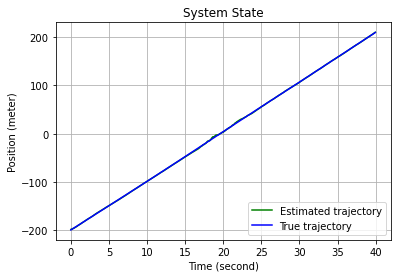

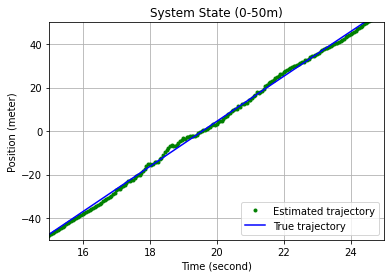

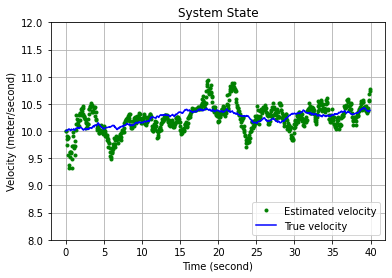

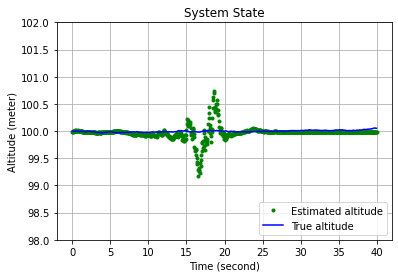

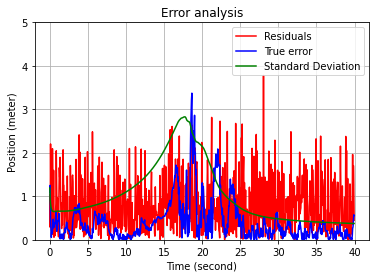

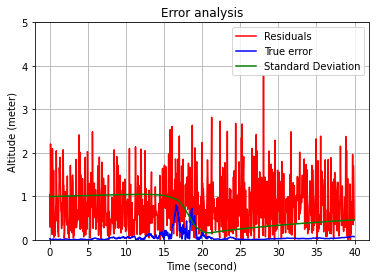

In [11]:
# Kalman Filter
# Measurement:
# Distance [meter]

# Imports
from numpy import arange, array, eye, sqrt, zeros, random, diag
from numpy.random import normal
from numpy.linalg import inv, norm, cholesky
import matplotlib.pyplot as plt
from vanloan.vanloan import numeval

# System values
dt = 0.05       # interval [second]
samples = 800   # number of samples
num = 3         # number of iterations (design matrix)
r = 1**2        # measurement noise [meter^2]
qv = 0.3**2     # process noise velocity [meter^2/second^3]
qh = 0.1**2     # process noise height [meter^2/second]

# Dynamics matrix
F = array([[0, 1, 0],
           [0, 0, 0],
           [0, 0, 0]])

# White noise coefficients
G = array([[0, 0],
           [sqrt(qv), 0],
           [0, sqrt(qh)]])

# Observation covariance matrix
R = array([[r]])    # [meter^2]

# Initial state
x = array([[-200],  # position [meter]
           [10],    # velocity [meter/second]
           [100]])  # height   [meter]
xt = x

# Inital state covariance matrix
P = diag([5**2, 1**2, 1**2])

# Numerical evaluation (van Loan)
[phi, Q] = numeval(F, G, dt)

# Cholesky decomposition of process noise covariance
C = cholesky(Q)

# Linearized design matrix
def dH(x_nom):
    
    x1 = x_nom[0, 0]
    x3 = x_nom[2, 0]

    dH = array([[x1/sqrt(x1**2 + x3**2), 0, x3/sqrt(x1**2 + x3**2)]])
    
    return dH

# Computed observations
def hx(x_nom):
    
    x1 = x_nom[0, 0]
    x3 = x_nom[2, 0]
    
    z = array([[sqrt(x1**2 + x3**2)]])
    
    return z

# Plot vectors
x_all = []; P_all = []; xt_all =[]
res = []; pos_err = []; hgt_err = []

# Main loop
for k in range(0, samples):
    
    # Process noise vector
    w = array([[0],
               [normal(0, sqrt(qv))],
               [normal(0, sqrt(qh))]])
    
    # Compute true trajectory
    xt = phi@xt + C@w
    
    # Generate noisy measurements
    z = hx(xt) + normal(0, sqrt(r))
    
    # Time update
    xp = phi@x
    Pp = phi@P@phi.T + Q
    
    for i in range(0, num):
        
        # Design matrix
        H = dH(x)
    
        # System size
        [n, e] = H.shape
        
        # Computed observations
        zp = hx(xp)
    
        # Kalman gain
        K = Pp@H.T@inv(H@Pp@H.T + R)
    
        # Measurement update
        x = xp + K@(z - zp)
        P = (eye(e) - K@H)@Pp@(eye(e) - K@H).T + K@R@K.T
    
    # Accumulate plot vectors
    x_all.append(x)
    P_all.append(P)
    xt_all.append(xt)

    res.append(norm(z - zp))
    pos_err.append(norm(xt[0] - x[0]))
    hgt_err.append(norm(xt[2] - x[2]))
    

# Extract plot vectors
pos_est = [x[0, 0] for x in x_all]
vel_est = [x[1, 0] for x in x_all]
hgt_est = [x[2, 0] for x in x_all]

pos_true = [xt[0, 0] for xt in xt_all]
vel_true = [xt[1, 0] for xt in xt_all]
hgt_true = [xt[2, 0] for xt in xt_all]

pos_std = [sqrt(P[0, 0]) for P in P_all]
hgt_std = [sqrt(P[2, 2]) for P in P_all]

# Time
time = arange(0, samples)*dt

plt.figure(1)
plt.plot(time, pos_est, 'g', label = 'Estimated trajectory')
plt.plot(time, pos_true, 'b', label = 'True trajectory')
plt.title('System State')
plt.xlabel('Time (second)')
plt.ylabel('Position (meter)')
plt.legend(loc='lower right')
plt.grid(True, which='both')
plt.show()

plt.figure(2)
plt.plot(time, pos_est, 'g.', label='Estimated trajectory')
plt.plot(time, pos_true, 'b', label='True trajectory')
plt.title('System State (0-50m)')
plt.xlabel('Time (second)')
plt.ylabel('Position (meter)')
plt.xlim(15, 25)
plt.ylim(-50, 50)
plt.legend(loc='lower right')
plt.grid(True, which='both')
plt.show()

plt.figure(3)
plt.plot(time, vel_est, 'g.', label='Estimated velocity')
plt.plot(time, vel_true, 'b', label='True velocity')
plt.title('System State')
plt.xlabel('Time (second)')
plt.ylabel('Velocity (meter/second)')
plt.ylim(8, 12)
plt.legend(loc='lower right')
plt.grid(True, which='both')
plt.show()

plt.figure(4)
plt.plot(time, hgt_est, 'g.', label='Estimated altitude')
plt.plot(time, hgt_true, 'b', label='True altitude')
plt.title('System State')
plt.xlabel('Time (second)')
plt.ylabel('Altitude (meter)')
plt.ylim(98, 102)
plt.legend(loc='lower right')
plt.grid(True, which='both')
plt.show()

plt.figure(5)
plt.plot(time, res, 'r', label='Residuals')
plt.plot(time, pos_err, 'b', label='True error')
plt.plot(time, pos_std, 'g', label='Standard Deviation')
plt.title('Error analysis')
plt.xlabel('Time (second)')
plt.ylabel('Position (meter)')
plt.ylim(0, 5)
plt.legend(loc='upper right')
plt.grid(True, which='both')
plt.show()

plt.figure(6)
plt.plot(time, res, 'r', label='Residuals')
plt.plot(time, hgt_err, 'b', label='True error')
plt.plot(time, hgt_std, 'g', label='Standard Deviation')
plt.title('Error analysis')
plt.xlabel('Time (second)')
plt.ylabel('Altitude (meter)')
plt.ylim(0, 5)
plt.legend(loc='upper right')
plt.grid(True, which='both')
plt.show()

Note the change in the estimated error around $t=20s$. The reason for this phenomenon is that the geometry of the measured range doesn't provide any information for the position/velocity as the drone is almost directly above the ranging sensor at this point in time.

## Summary

*Prediction:*

$$
\begin{align}
  \tilde x_{k}=&\phi_{k-1} \hat x_{k-1}\\
  \tilde P_{k}=&\phi_{k-1} P_{k-1} \phi^T_{k-1}+Q_{k-1}\\
\end{align}
$$

*Correction:*

$$
\begin{align}
  K_{k}=&\tilde P_{k}H^{T}_{k}(H_{k} \tilde P_{k}H^{T}_{k}+R_{k})^{-1}\\
  \hat x_{k}=&\tilde x_{k}+K_{k}(z_{k}-H_{k} \tilde x_{k})\\
  \hat P_{k}=&(I-K_{k}H_{k})\tilde P_{k}(I-K_{k}H_{k})^T+K_{k}R_{k}K_{k}^T\\
\end{align}
$$